In [2]:
import tensorflow 
import cv2
import numpy as np
import math
import os
import sys
import keras
import matplotlib
import skimage
import zipfile
import shutil
import glob

from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt

%matplotlib inline

# print('Python: {}'.format(sys.version))
# print('Keras: {}'.format(keras.__version__))
# print('OpenCV: {}'.format(cv2.__version__))
# print('NumPy: {}'.format(numpy.__version__))
# print('Matplotlib: {}'.format(matplotlib.__version__))
# print('Scikit-Image: {}'.format(skimage.__version__))

# Новый раздел

In [3]:
source_images = 'source'
dataset_dir = 'dataset'
train_dir = dataset_dir + '/train'
valid_dir = dataset_dir + '/valid'

In [4]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/frames.zip', 'r')
os.mkdir(source_images) if not os.path.isdir(source_images) else None
zip_ref.extractall(source_images)
zip_ref.close()

In [5]:
files = glob.glob(source_images + '/*')
if len(files) == 0:
    print("No files in source directory, either files weren't uploaded or they were moved to 'dataset' directory")
else:
    train_size = int(len(files) * 0.8)
    validation_size = len(files) - train_size

    train_files = np.random.choice(files, train_size, replace=False)
    os.mkdir(dataset_dir) if not os.path.isdir(dataset_dir) else None
    os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
    for fn in train_files:
        shutil.move(fn, train_dir)
    train_files = glob.glob(train_dir + '/*')

    validation_files = glob.glob(source_images + '/*')
    os.mkdir(valid_dir) if not os.path.isdir(valid_dir) else None
    for fn in validation_files:
        shutil.move(fn, valid_dir)
    validation_files = glob.glob(valid_dir + '/*')

In [6]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_dataset(images, factor=2, size=300):

    imgs_ref = [cv2.resize(cv2.imread(image), (size, size)).astype('float32') / 255 for image in images]
    imgs_ref = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in imgs_ref]
    h, w, _ = imgs_ref[0].shape
    new_height = int(h / factor)
    new_width = int(w / factor)
    imgs_lr = [cv2.resize(img, (new_width, new_height)) for img in imgs_ref]
    imgs_lr = [cv2.resize(img, (w, h)) for img in imgs_lr]
    imgs_ref = np.array(imgs_ref)
    imgs_lr = np.array(imgs_lr)
    return imgs_ref, imgs_lr

In [7]:
train_ref, train_lr = prepare_dataset(train_files, 2, 500)
valid_ref, valid_lr = prepare_dataset(validation_files, 2, 500)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(train_ref[102])
axes[1].imshow(train_lr[102])

# Load dataset

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
keras.utils.get_file(origin=dataset_url, fname="/content/BSR", untar=True, cache_dir='/content')

70770688/70763455 [==============================] - 21s 0us/step


'/content/BSR'

In [3]:
def prepare_dataset(images, factor=2, size=300):

    imgs_ref = [cv2.resize(cv2.imread(image), (size, size)).astype('float32') / 255 for image in images]
    imgs_ref = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in imgs_ref]
    h, w, _ = imgs_ref[0].shape
    new_height = int(h / factor)
    new_width = int(w / factor)
    imgs_lr = [cv2.resize(image, (new_width, new_height)) for image in imgs_ref]
    imgs_lr = [cv2.resize(image, (w, h)) for image in imgs_lr]
    imgs_ref = np.array(imgs_ref)
    imgs_lr = np.array(imgs_lr)
    return imgs_ref, imgs_lr

In [4]:
crop_size = 300
upscale_factor = 3

train_dir = '/content/datasets/BSR/BSDS500/data/images/train'
test_dir = '/content/datasets/BSR/BSDS500/data/images/test'
valid_dir = '/content/datasets/BSR/BSDS500/data/images/val'

files = glob.glob(test_dir + '/*.jpg')
for fn in files:
    shutil.move(fn, train_dir)

train_ref, train_lr = prepare_dataset(glob.glob(train_dir + '/*jpg'), upscale_factor, crop_size)
valid_ref, valid_lr = prepare_dataset(glob.glob(valid_dir + '/*jpg'), upscale_factor, crop_size)

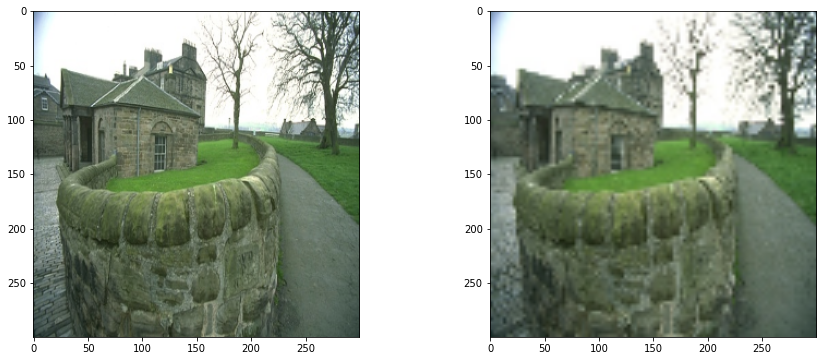

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(train_ref[37])
axes[1].imshow(train_lr[37])

# Модель


In [10]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=64, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None, None, 3)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=32, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [11]:
srcnn = model()

In [12]:
WEIGHTS_LOAD = 'srcnn_weights.h5'
WEIGHTS_SAVE = 'srcnn_weights.h5'

In [ ]:
srcnn.load_weights(WEIGHTS_LOAD)

In [13]:
srcnn.fit(train_lr, train_ref, 
          batch_size=16,
          epochs=50,
          # callbacks=callbacks,
          validation_data=(valid_lr, valid_ref),
          validation_batch_size = 8)

Epoch 1/50
31/31 [==============================] - 81s 1s/step - loss: 0.0715 - mean_squared_error: 0.0715 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 2/50
31/31 [==============================] - 30s 960ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/50
31/31 [==============================] - 30s 971ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 4/50
31/31 [==============================] - 30s 962ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 5/50
31/31 [==============================] - 30s 967ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/50
31/31 [==============================] - 30s 971ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/50
31/31 [=======

In [14]:
srcnn.save_weights(WEIGHTS_SAVE)

In [16]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    os.mkdir("images") if not os.path.isdir("images") else None

    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
prepare_images('source/', 2)

Saving barbara.bmp
Saving bridge.bmp
Saving baby_GT.bmp
Saving ppt3.bmp
Saving lenna.bmp
Saving baboon.bmp
Saving coastguard.bmp
Saving zebra.bmp
Saving bird_GT.bmp
Saving foreman.bmp
Saving face.bmp
Saving woman_GT.bmp
Saving man.bmp
Saving head_GT.bmp
Saving butterfly_GT.bmp
Saving flowers.bmp
Saving monarch.bmp
Saving comic.bmp
Saving pepper.bmp


In [17]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [18]:
def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights(WEIGHTS_LOAD)
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # perform super-resolution with srcnn
    input = cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB) / 255
    output = srcnn.predict(np.expand_dims(input, axis=0))
    
    # post-process output
    output = np.squeeze(output, axis=0)
    output *= 255
    output[output[:] > 255] = 255
    output[output[:] < 0] = 0
    output = output.astype(np.uint8)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)    
    
    # image quality calculations
    # scores = []
    # scores.append(compare_images(degraded, ref))
    # scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output


In [19]:
def crop_image(img):
    height, width = img.shape[0], img.shape[1]
    first = (max(height, width) - min(height, width)) // 2 
    second = first + min(height, width)
    if width > height:
        return img[:, first:second]
    else:
        return img[first:second, :]

In [20]:
def choose_quarter(size, borders):
    left, right, bottom, top = borders
    if left < size - right - 1:
        if top > size - 1 - bottom:
            return [0.6, 0.6, 0.35, 0.35]
        else:
            return [0.6, 0.05, 0.35, 0.35]
    else:
        if top > size - 1 - bottom:
            return [0.05, 0.6, 0.35, 0.35]
        else:
            return [0.05, 0.05, 0.35, 0.35]


In [21]:
def display_images(image_path, borders = [0, 50, 50, 0], save_path = None):
    # preparations
    ref, degraded, output = predict(image_path)
    
    # crop images
    ref = crop_image(ref)
    degraded = crop_image(degraded)
    output = crop_image(output)
    size = ref.shape[0]

    # display images
    fig, axs = plt.subplots(1, 3, figsize=(26, 8))
    titles = ['Original', 'Degraded', 'SRCNN']
    images = [ref, degraded, output]
    for i in range(3):
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axs[i].set_title(titles[i])
        axins = axs[i].inset_axes(choose_quarter(size, borders))
        axins.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axins.set_xlim(borders[0], borders[1])
        axins.set_ylim(borders[2], borders[3])
        axins.set_xticks([])
        axins.set_yticks([])
        rectangle, lines = axs[i].indicate_inset_zoom(axins, linewidth = 4, edgecolor='red')
        for line in lines:
            line.set_visible(False)
        
    # save images
    if save_path is not None:
        _, file = os.path.split(image_path)
        os.mkdir(save_path) if not os.path.isdir(save_path) else None
        fig.savefig(save_path + '/{}.png'.format(os.path.splitext(file)[0]))

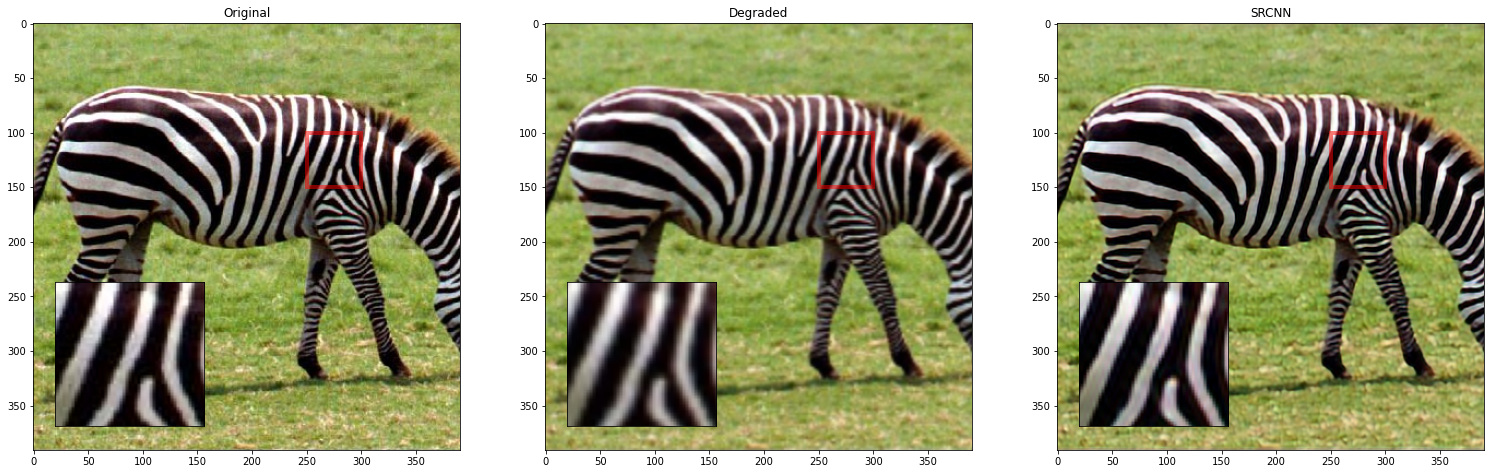

In [49]:
img_path = '/content/images/zebra.bmp'
borders = [250, 300, 150, 100]
save_dir = 'comparison'
display_images(img_path, borders, save_dir)

In [ ]:
os.mkdir("output") if not os.path.isdir("output") else None
os.mkdir("output/upscaled") if not os.path.isdir("output/upscaled") else None
os.mkdir("output/degraded") if not os.path.isdir("output/degraded") else None
os.mkdir("output/input") if not os.path.isdir("output/input") else None

for file in os.listdir('images'):
    input, degraded, output = predict('images/{}'.format(file))
    cv2.imwrite('output/upscaled/{}'.format(file), output)
    cv2.imwrite('output/degraded/{}'.format(file), degraded)
    cv2.imwrite('output/input/{}'.format(file), input)

In [ ]:
os.mkdir("downloads") if not os.path.isdir("downloads") else None
!zip -r /content/downloads/referenceImages.zip /content/output/input
!zip -r /content/downloads/lowResolutionImages.zip /content/output/degraded
!zip -r /content/downloads/restoredImages.zip /content/output/upscaled
!zip -r /content/downloads/comparison.zip /content/comparison